In [14]:
import PIL
import matplotlib.pyplot as plt
import json
import random

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

import torchvision
from torchvision import transforms

# from where_am_i_located.lib.autoencoder import MobileNetV2CAE
# from where_am_i_located.lib.data_loader import CampusImagesDataSet
from lib.autoencoder import MobileNetV2CAE
from lib.data_loader import CampusImagesDataSet, all_transforms

In [17]:
# directory locations
# dir = "./where_am_i_located"
dir = "./"
train_dir = f"{dir}/data/train/processed"
test_dir = f"{dir}/data/test/processed"

grid_size = 2

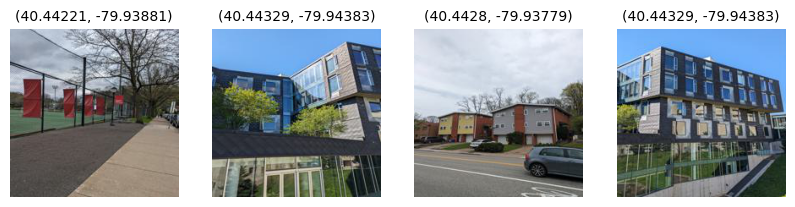

In [9]:
fig, axs = plt.subplots(1, 4, figsize=(10, 5))

with open(f"{train_dir}/labels.json", "r") as file:
  labels = json.load(file)
  images = random.sample(list(labels.keys()), 4)
  for i, path in enumerate(images):
    im = PIL.Image.open(f"{train_dir}/{path}")
    axs[i].imshow(im)
    axs[i].axis("off")
    axs[i].set_title(f"{labels[path][0], labels[path][1]}", fontsize=10)

plt.show()

In [11]:
def load_places365():
    # standard image preprocessing
    transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])

    # load places dataset
    places365_train = torchvision.datasets.Places365(root='./data', split='val', transform=transform, download=True, small=True)
    return places365_train

places365_train = load_places365()

100%|██████████| 67498496/67498496 [00:12<00:00, 5471711.97it/s]


Extracting ./data/filelist_places365-standard.tar to ./data


100%|██████████| 525158400/525158400 [01:48<00:00, 4820616.46it/s]


Extracting ./data/val_256.tar to ./data


In [18]:
cmu_train_data = CampusImagesDataSet(train_dir, transform=all_transforms, grid_size=grid_size)
cmu_test_data = CampusImagesDataSet(test_dir, transform=all_transforms, grid_size=grid_size)

In [16]:

def create_CAE_train_utils(model):
    trainDL = DataLoader(CampusImagesDataSet('data/train/processed', transform=all_transforms, grid_size=grid_size), batch_size=16, shuffle=True)
    testDL = DataLoader(CampusImagesDataSet('data/test/processed', transform=all_transforms, grid_size=grid_size), batch_size=16, shuffle=True)
    lossfn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    return trainDL, testDL, lossfn, opt

# Define dataset
indices = [i for i in range(20000)]
places365_train = Subset(places365_train, indices)
train_loader = DataLoader(places365_train, batch_size=32, shuffle=True)

# Training hyperparameters
num_epochs = 25
learning_rate = 0.001

# Define model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MobileNetV2CAE(in_channels=3).to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

32


In [13]:
# Hyperparameters
num_epochs = 25
learning_rate = 0.001

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV2CAE(in_channels=3).to(device)
model = model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
# Training the model
model.train()
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
          print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    if loss.item() < 0.5:
      break

Epoch [1/25], Step [1/157], Loss: 1.6942


KeyboardInterrupt: 

In [ ]:
cid = CampusImagesDataSet('where_am_i_located/data/train/processed', transform=transform, grid_size=2)

model.eval()

latent_space = []
labels = []

with torch.no_grad():
    for image, lbl in cid:
        image = image.unsqueeze(0).to(device)
        encoded = model.encoder(image).view(image.size(0), -1).cpu().numpy()
        latent_space.append(encoded)
        labels.append(int(torch.argmax(lbl)))

In [ ]:
latent_space = np.vstack(latent_space)
labels = np.array(labels)

tsne = TSNE(n_components=2, random_state=42)
latent_2D = tsne.fit_transform(latent_space)

# Visualize the latent space using t-SNE
plt.figure(figsize=(10, 10))
for i in range(4):
    indices = labels == i
    plt.scatter(latent_2D[indices, 0], latent_2D[indices, 1], label=f'{i}', alpha=0.6)

plt.legend()
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title('t-SNE Visualization of Latent Space')
plt.show()